# Pipeline processing using Dask

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from processing_components.calibration.calibration import solve_gaintable
from processing_components.calibration.operations import apply_gaintable
from processing_components.calibration.calibration_control import create_calibration_controls
from processing_components.visibility.base import create_blockvisibility
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.deconvolution import deconvolve_cube
from processing_components.image.operations import show_image, export_image_to_fits, qa_image
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.util.testing_support import create_named_configuration, create_low_test_image_from_gleam
from processing_components.imaging.base import predict_2d, create_image_from_visibility, advise_wide_field

from processing_components.component_support.dask_init import get_dask_Client
from processing_components.components.imaging_components import invert_component, predict_component, \
    deconvolve_component
from processing_components.components.support_components import simulate_component, \
    corrupt_component
from processing_components.components.pipeline_components import continuum_imaging_component, \
    ical_component

from processing_components.component_support.arlexecute import arlexecute

import pprint

pp = pprint.PrettyPrinter()

import logging

def init_logging():
    log = logging.getLogger()
    logging.basicConfig(filename='%s/imaging-pipeline.log' % results_dir,
                        filemode='a',
                        format='%(thread)s %(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.INFO)
log = logging.getLogger()
logging.info("Starting imaging-pipeline")


We will use dask

In [2]:
arlexecute.set_client(get_dask_Client())
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
<Client: scheduler='tcp://127.0.0.1:54813' processes=8 cores=8>
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:54822': None,
 'tcp://127.0.0.1:54824': None,
 'tcp://127.0.0.1:54827': None,
 'tcp://127.0.0.1:54828': None,
 'tcp://127.0.0.1:54832': None,
 'tcp://127.0.0.1:54838': None,
 'tcp://127.0.0.1:54844': None,
 'tcp://127.0.0.1:54845': None}

In [3]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [4]:
nfreqwin=7
ntimes=11
rmax=300.0
frequency=numpy.linspace(0.9e8,1.1e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

vis_list=create_simulate_vis_graph('LOWBD2',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre,
                                         order='frequency',
                                        rmax=rmax)
print('%d elements in vis_list' % len(vis_list))
log.info('About to make visibility')
vis_list = arlexecute.compute(vis_list, sync=True)

7 elements in vis_list
arlexecute.compute: Synchronous execution took 2.088 seconds


In [5]:
wprojection_planes=1
advice_low=advise_wide_field(vis_list[0], guard_band_image=8.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

advice_high=advise_wide_field(vis_list[-1], guard_band_image=8.0, delA=0.02,
                              wprojection_planes=wprojection_planes)

vis_slices = advice_low['vis_slices']
npixel=advice_high['npixels2']
cellsize=min(advice_low['cellsize'], advice_high['cellsize'])

Now make a graph to fill with a model drawn from GLEAM 

In [6]:
gleam_model = [arlexecute.execute(create_low_test_image_from_gleam)(npixel=npixel,
                                                               frequency=[frequency[f]],
                                                               channel_bandwidth=[channel_bandwidth[f]],
                                                               cellsize=cellsize,
                                                               phasecentre=phasecentre,
                                                               polarisation_frame=PolarisationFrame("stokesI"),
                                                               flux_limit=1.0,
                                                               applybeam=True)
                     for f, freq in enumerate(frequency)]
log.info('About to make GLEAM model')
gleam_model = arlexecute.compute(gleam_model, sync=True)
future_gleam_model = arlexecute.scatter(gleam_model)

arlexecute.compute: Synchronous execution took 54.066 seconds


In [7]:
log.info('About to run predict to get predicted visibility')
future_vis_graph = arlexecute.scatter(vis_list)
predicted_vislist = predict_component(future_vis_graph, gleam_model,  
                                                context='wstack', vis_slices=vis_slices)
predicted_vislist = arlexecute.compute(predicted_vislist, sync=True)
corrupted_vislist = corrupt_component(predicted_vislist, phase_error=1.0)
log.info('About to run corrupt to get corrupted visibility')
corrupted_vislist =  arlexecute.compute(corrupted_vislist, sync=True)
future_predicted_vislist=arlexecute.scatter(predicted_vislist)

arlexecute.compute: Synchronous execution took 31.145 seconds
arlexecute.compute: Synchronous execution took 1.197 seconds


Get the LSM. This is currently blank.

In [8]:
model_list = [arlexecute.execute(create_image_from_visibility)(vis_list[f],
                                                     npixel=npixel,
                                                     frequency=[frequency[f]],
                                                     channel_bandwidth=[channel_bandwidth[f]],
                                                     cellsize=cellsize,
                                                     phasecentre=phasecentre,
                                                     polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]

In [9]:
future_predicted_vislist=arlexecute.scatter(predicted_vislist)
dirty_graph = invert_component(future_predicted_vislist, model_list, 
                                  context='wstack',
                                  vis_slices=vis_slices, dopsf=False)
psf_graph = invert_component(future_predicted_vislist, model_list, 
                                context='wstack',
                                vis_slices=vis_slices, dopsf=True)

Create and execute graphs to make the dirty image and PSF

arlexecute.compute: Synchronous execution took 22.733 seconds
Image:
	Shape: (1, 1, 512, 512)
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 30.0  -60.0  1.0  90000000.0  
CRPIX : 257.0  257.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.091123386639907  0.091123386639907  1.0  3333333.3333333  
NAXIS : 0  0
	Polarisation frame: stokesI



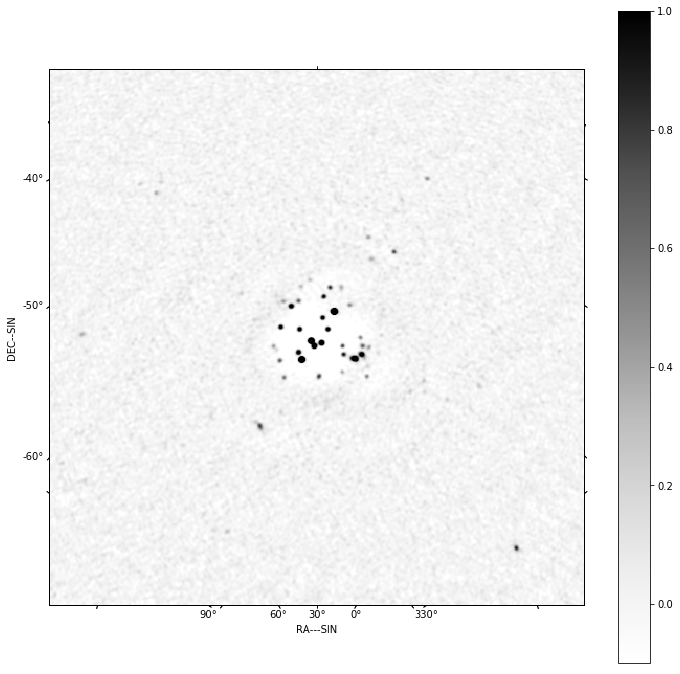

arlexecute.compute: Synchronous execution took 25.780 seconds


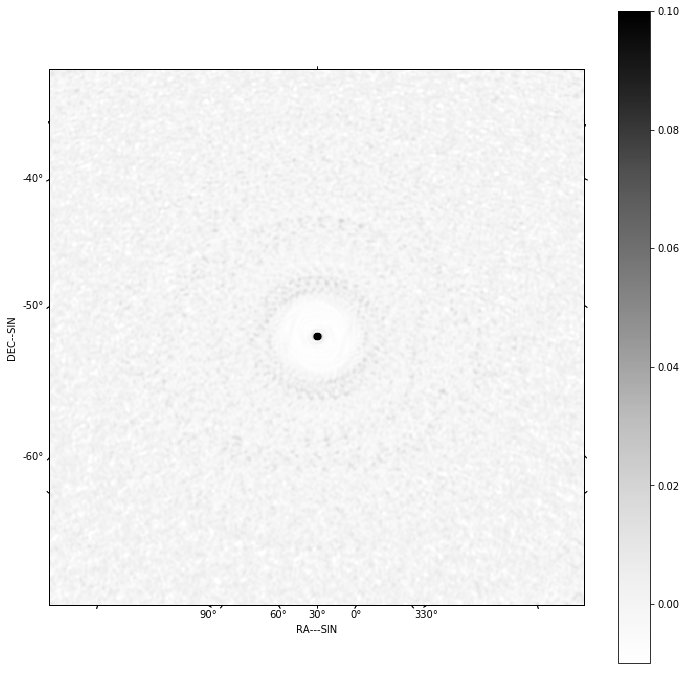

In [10]:
log.info('About to run invert to get dirty image')

dirty_graph =  arlexecute.compute(dirty_list, sync=True)
dirty = dirty_graph[0][0]
show_image(dirty, cm='Greys', vmax=1.0, vmin=-0.1)
plt.show()

log.info('About to run invert to get PSF')


psf_graph =  arlexecute.compute(psf_list, sync=True)
psf = psf_graph[0][0]
show_image(psf, cm='Greys', vmax=0.1, vmin=-0.01)
plt.show()

Now deconvolve using msclean

arlexecute.compute: Synchronous execution took 5.244 seconds


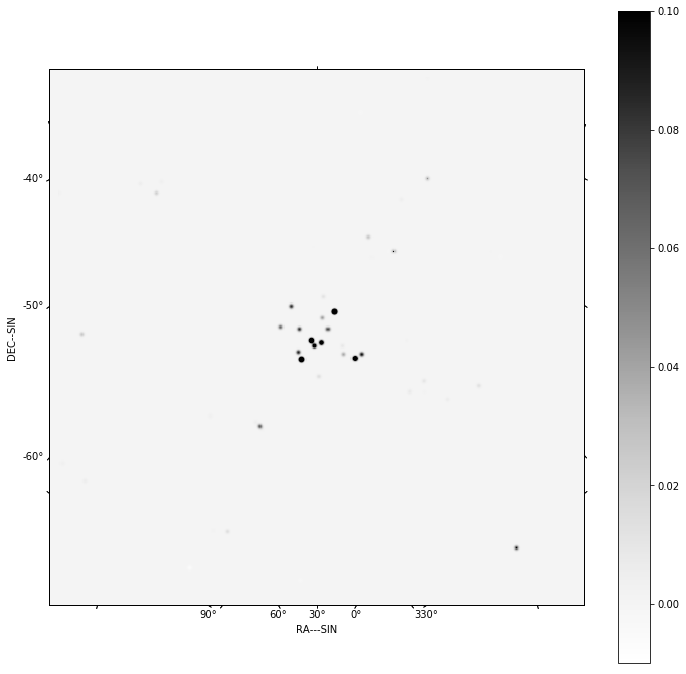

In [11]:
log.info('About to run deconvolve')

deconvolve_list, _ = \
    deconvolve_component(dirty_graph, psf_graph, model_graph=model_list, 
                            deconvolve_facets=8, deconvolve_overlap=16, deconvolve_taper='tukey',
                            scales=[0, 3, 10],
                            algorithm='msclean', niter=1000, 
                            fractional_threshold=0.1,
                            threshold=0.1, gain=0.1, psf_support=64)
    
deconvolved = arlexecute.compute(deconvolve_list, sync=True)
show_image(deconvolved[0], cm='Greys', vmax=0.1, vmin=-0.01)
plt.show()

In [12]:
continuum_imaging_list = \
    continuum_imaging_component(predicted_vislist, 
                                            model_graph=model_list, 
                                            context='wstack', vis_slices=vis_slices, 
                                            scales=[0, 3, 10], algorithm='mmclean', 
                                            nmoment=3, niter=1000, 
                                            fractional_threshold=0.1,
                                            threshold=0.1, nmajor=5, gain=0.25,
                                            deconvolve_facets = 8, deconvolve_overlap=16, 
                                            deconvolve_taper='tukey', psf_support=64)


/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 4.68 MB detected in task graph: 
  (<data_models.memory_data_models.BlockVisibility o ...  0x10c7bbf28>,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


arlexecute.compute: Synchronous execution took 411.446 seconds
Quality assessment:
	Origin: qa_image
	Context: Clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.59626031915124'
		min: '-0.11571033015267226'
		rms: '0.02331830942893396'
		sum: '65.5955166004128'
		medianabs: '0.0'
		median: '0.0'



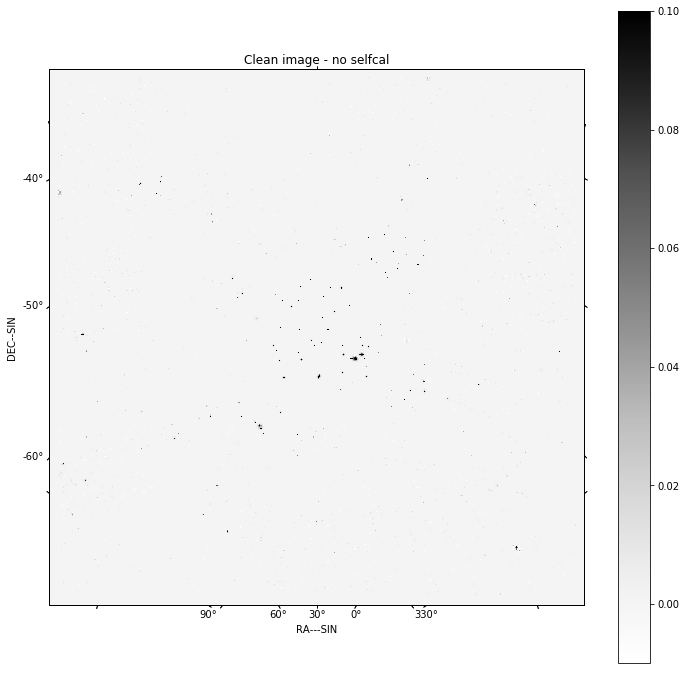

Quality assessment:
	Origin: qa_image
	Context: Restored clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.680406313661887'
		min: '-0.01319866028119841'
		rms: '0.07814754554240548'
		sum: '1292.047332252095'
		medianabs: '0.0022825792051581204'
		median: '-0.00019221194580494496'



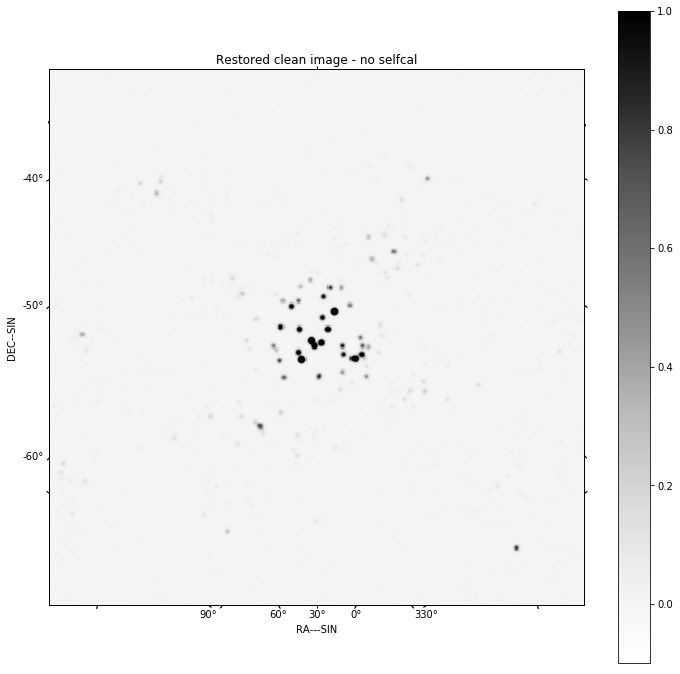

Quality assessment:
	Origin: qa_image
	Context: Residual clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '0.13061174081629'
		min: '-0.12652133554122294'
		rms: '0.005756973710022481'
		sum: '11.591768602500881'
		medianabs: '0.0025830870945915503'
		median: '-0.0003582433179414722'



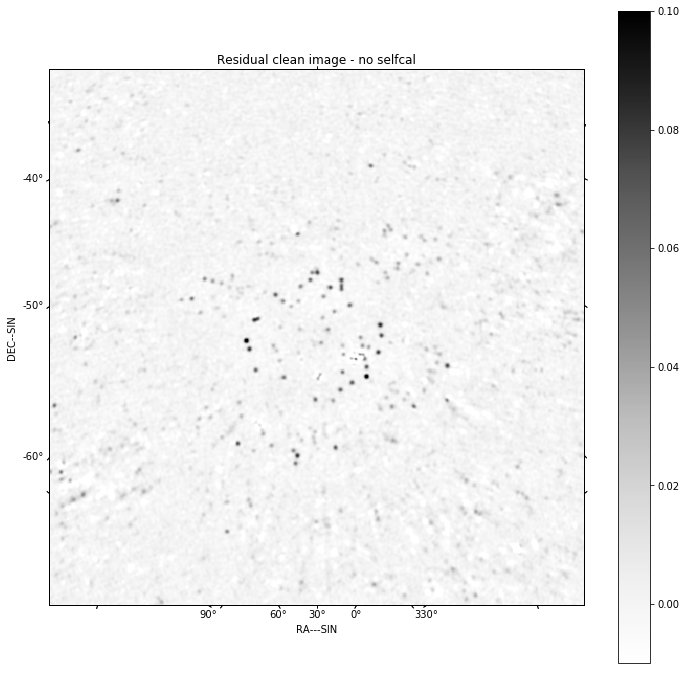

In [13]:
log.info('About to run continuum imaging')

result=arlexecute.compute(continuum_imaging_list, sync=True)
deconvolved = result[0][0]
residual = result[1][0]
restored = result[2][0]

f=show_image(deconvolved, title='Clean image - no selfcal', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(deconvolved, context='Clean image - no selfcal'))

plt.show()

f=show_image(restored, title='Restored clean image - no selfcal', 
             cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_continuum_imaging_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image - no selfcal', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_continuum_imaging_residual.fits' 
                     %(results_dir))

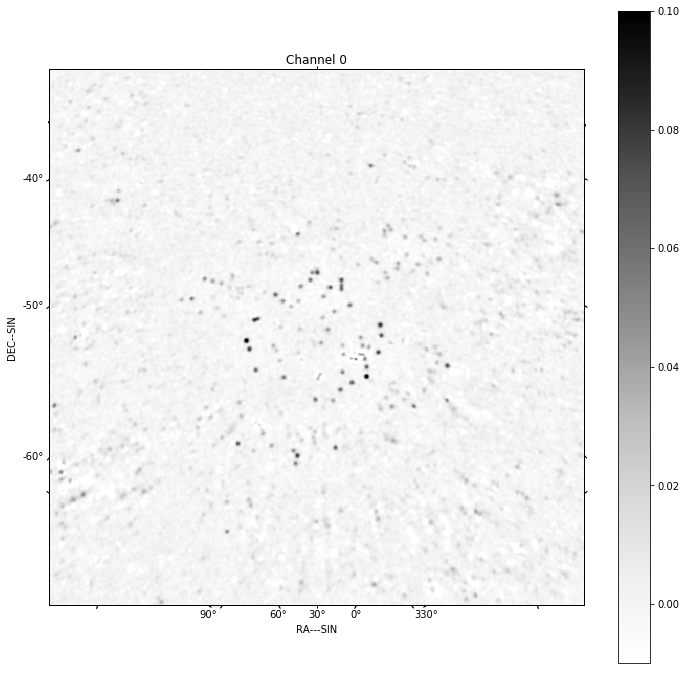

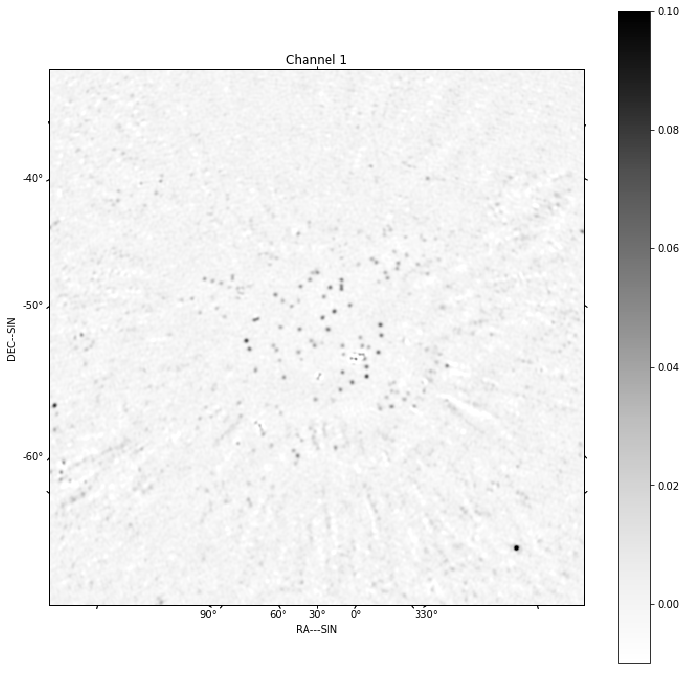

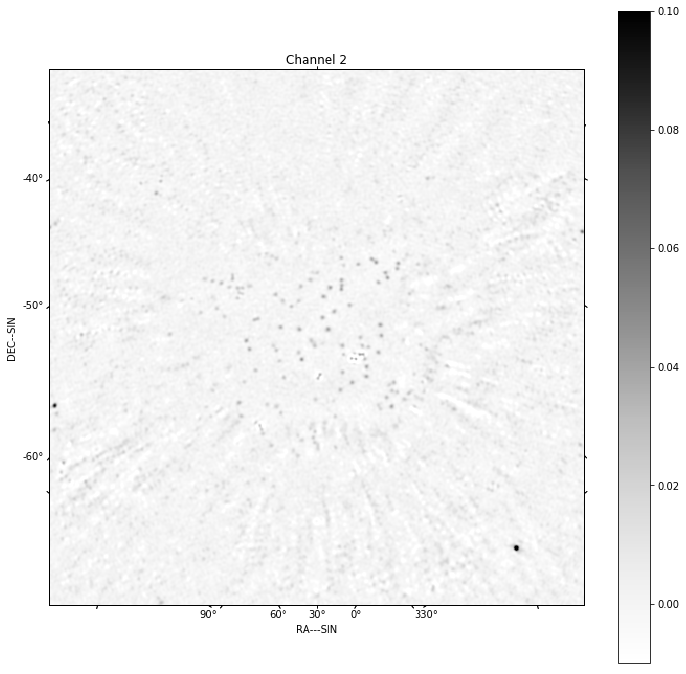

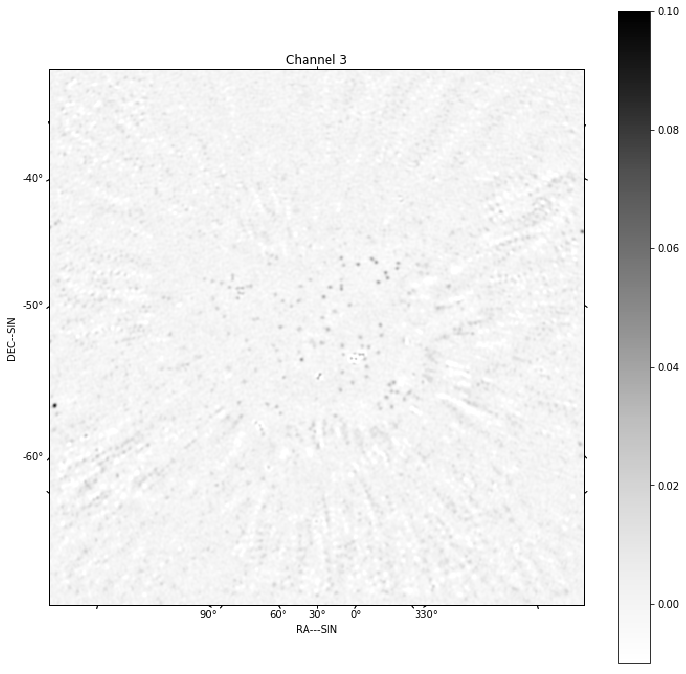

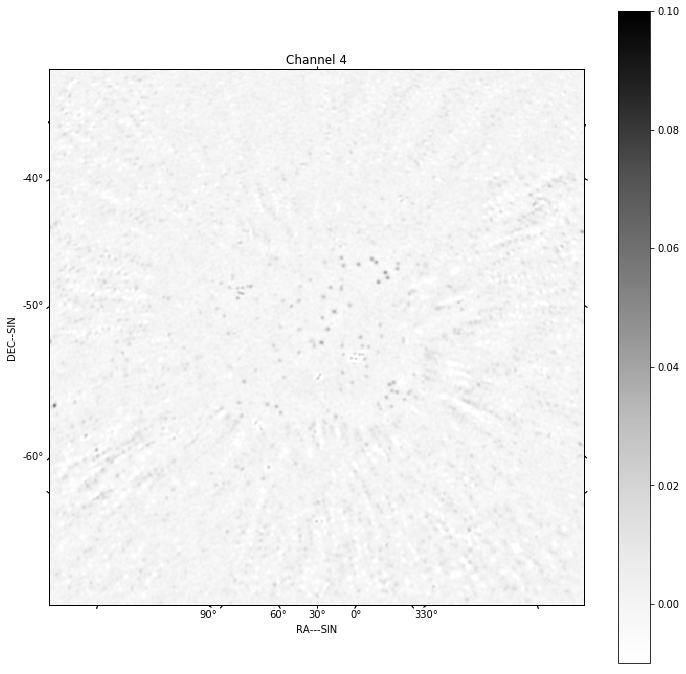

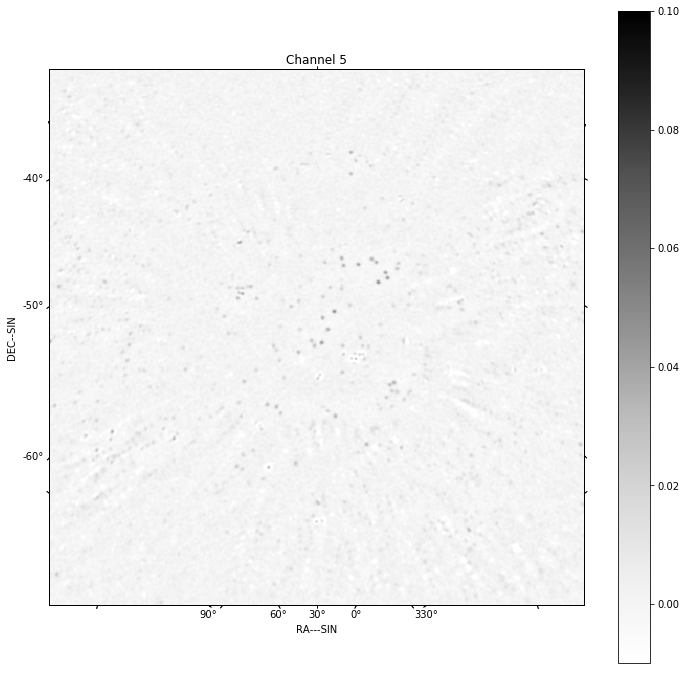

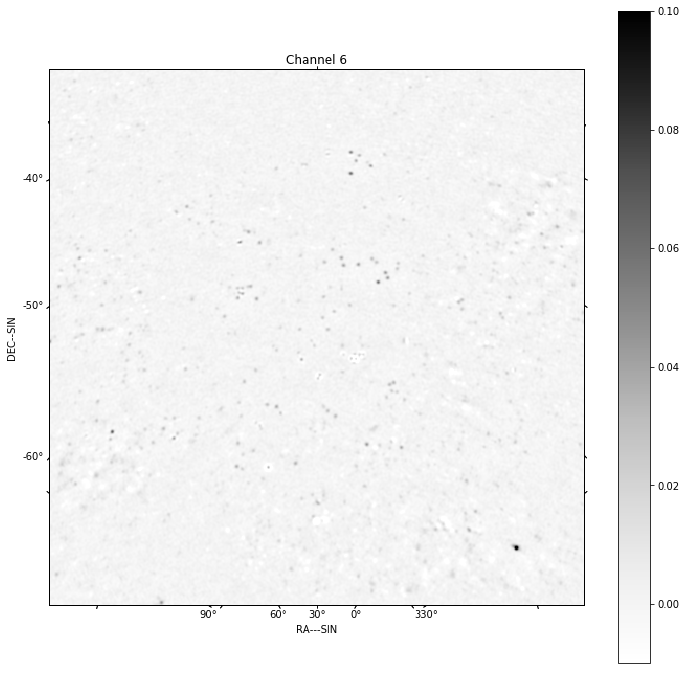

In [14]:
for chan in range(nfreqwin):
    residual = result[1][chan]
    show_image(residual[0], title='Channel %d' % chan, cm='Greys', 
               vmax=0.1, vmin=-0.01)
    plt.show()

In [15]:
controls = create_calibration_controls()
        
controls['T']['first_selfcal'] = 1
controls['G']['first_selfcal'] = 3
controls['B']['first_selfcal'] = 4

controls['T']['timescale'] = 'auto'
controls['G']['timescale'] = 'auto'
controls['B']['timescale'] = 1e5

pp.pprint(controls)

{'B': {'first_selfcal': 4,
       'phase_only': False,
       'shape': 'vector',
       'timescale': 100000.0,
       'timeslice': 100000.0},
 'G': {'first_selfcal': 3,
       'phase_only': False,
       'shape': 'vector',
       'timescale': 'auto',
       'timeslice': 60.0},
 'I': {'first_selfcal': 0,
       'phase_only': True,
       'shape': 'vector',
       'timeslice': 1.0},
 'P': {'first_selfcal': 0,
       'phase_only': False,
       'shape': 'matrix',
       'timeslice': 10000.0},
 'T': {'first_selfcal': 1,
       'phase_only': True,
       'shape': 'scalar',
       'timescale': 'auto',
       'timeslice': 'auto'}}


In [16]:
future_corrupted_vislist = arlexecute.client.scatter(corrupted_vislist)
ical_list = ical_component(future_corrupted_vislist, 
                                        model_graph=model_list,  
                                        context='wstack', 
                                        calibration_context = 'TG', 
                                        controls=controls,
                                        scales=[0, 3, 10], algorithm='mmclean', 
                                        nmoment=3, niter=1000, 
                                        fractional_threshold=0.1,
                                        threshold=0.1, nmajor=5, gain=0.25,
                                        deconvolve_facets = 8, 
                                        deconvolve_overlap=16,
                                        deconvolve_taper='tukey',
                                        vis_slices=ntimes,
                                        timeslice='auto',
                                        global_solution=False, 
                                        psf_support=64,
                                        do_selfcal=True)

arlexecute.compute: Synchronous execution took 348.624 seconds
Quality assessment:
	Origin: qa_image
	Context: Clean image
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.627679106099904'
		min: '-0.08128802175192572'
		rms: '0.023226603611101678'
		sum: '54.82071530774619'
		medianabs: '0.0'
		median: '0.0'



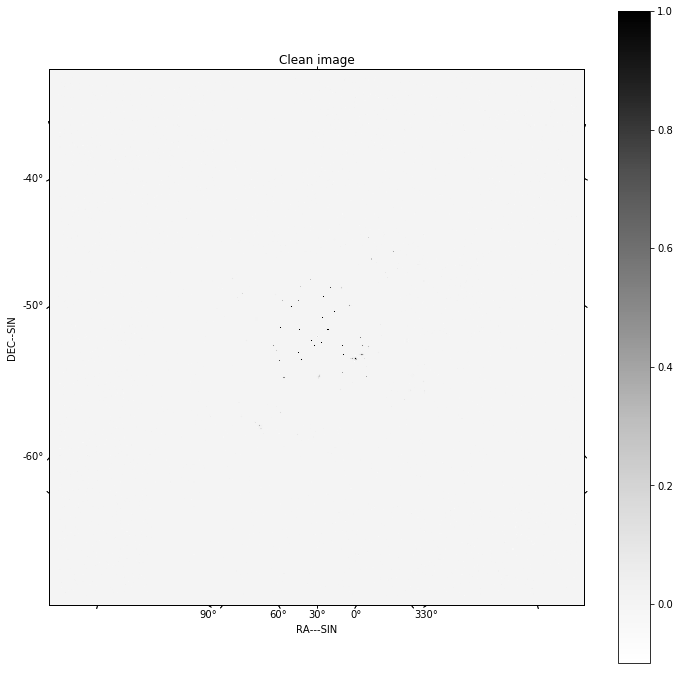

Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.684828077817974'
		min: '-0.11671659675798307'
		rms: '0.07791494802875601'
		sum: '1072.1559802342088'
		medianabs: '0.0047683523275218135'
		median: '1.1851033837137958e-05'



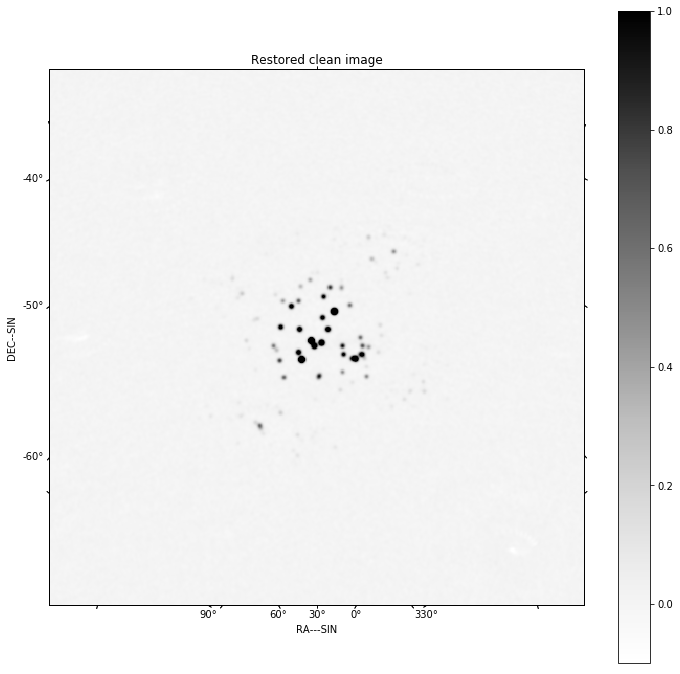

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: '(1, 1, 512, 512)'
		max: '0.10275496927092977'
		min: '-0.06934195893222528'
		rms: '0.008070510781826872'
		sum: '2.030328214069047'
		medianabs: '0.004955243704602113'
		median: '-8.400493725041095e-05'



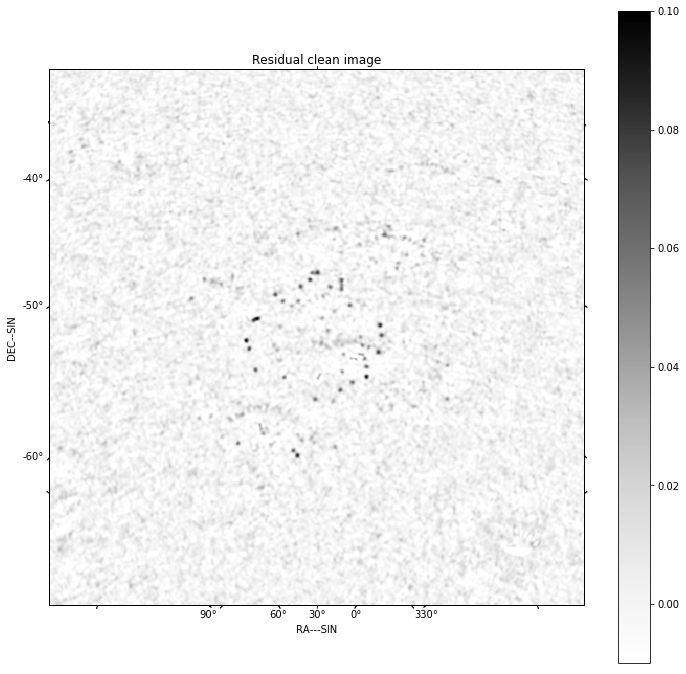

In [17]:
log.info('About to run ical')
result=arlexecute.compute(ical_list, sync=True)
deconvolved = result[0][0]
residual = result[1][0]
restored = result[2][0]

f=show_image(deconvolved, title='Clean image', cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f=show_image(restored, title='Restored clean image', cm='Greys', vmax=1.0, 
             vmin=-0.1)
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_ical_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(residual[0], context='Residual clean image'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_ical_residual.fits' 
                     %(results_dir))